# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

import torch

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

2024-08-21 22:31:16.164769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 22:31:16.181041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 22:31:16.186099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 22:31:16.200414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 22:31:17.160432: W tensorflow/compiler/tf2

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
from BGlib import be as belib


In [4]:
import pkg_resources

# Check the version of BGlib
bg_version = pkg_resources.get_distribution("BGlib").version
bg_version

'0.0.6'

In [5]:
import warnings
warnings.filterwarnings('ignore') 

In [6]:
pkg_resources.get_distribution("numpy").version

'1.26.4'

In [7]:
import sys
sys.version

'3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]'

## Loads data

In [8]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import os

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# The engineering components supporting BGlib:
import sidpy
import pyUSID as usid
# Finally, BGlib itself
from BGlib import be as belib

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from IPython.display import Video
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim
from sklearn.model_selection import train_test_split


# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './Figures/')

set_style("printing")
random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [9]:
max_mem = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
# Number of logical cores to use in fitting.  None uses all but 2 available cores.
max_cores = None
results_to_new_file = False

In [10]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_7_25.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

h5_path = save_path + filename

Using files already downloaded


In [11]:
# h5_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_manual.h5"

h5_path = save_path + filename

folder_path, h5_raw_file_name = os.path.split(h5_path)
h5_file = h5py.File(h5_path, 'r+')
print('Working on:\n' + h5_path)

h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

# h5_main

Working on:
./Data/data_raw_7_25.h5


In [12]:
print('Datasets and datagroups within the file:\n------------------------------------')
sidpy.hdf.hdf_utils.print_tree(h5_file)

print('\nThe main dataset:\n------------------------------------')
print(h5_main)

print('\nMetadata or attributes in the measurement datagroup\n------------------------------------')
for key, val in sidpy.hdf.hdf_utils.get_attributes(h5_main.parent.parent).items():
    print('{} : {}'.format(key, val))

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectr

In [13]:
# instantiate the dataset object
dataset = BE_Dataset(h5_path, SHO_fit_func_LSQF=SHO_fit_func_nn)


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [14]:
# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
  ├ Raw_Data-SHO_Fit_000
    ----

In [15]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit(force=True, max_cores=20)

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (9 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (9 members)>]
Returned previously computed results at /Measurement_000/Raw_Data-SHO_Fit_000

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (9 members)>]
Returned previously computed results at /M

In [16]:
data_path = save_path + '/' + filename

dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_fit_func_nn)

# instantiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]


BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/hysteresis_comparison.png
./Figures/hysteresis_comparison.svg


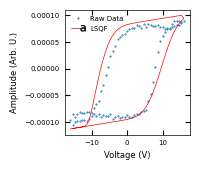

In [17]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [18]:



data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, 
              dataset,
              path='Trained Models/Hysteresis Fitter/', 
              training=True, 
              model_basename="Hysteresis_Loop_Fitter")

X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)
X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = False

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/Hysteresis Fitter/Hysteresis_Loop_Fitter_model_optimizer_Trust Region CG_epoch_599_train_loss_0.006924134410089917.pth"
    )

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
Using GPU NVIDIA GeForce RTX 3090


### Evaluate the Neural Network Results

./Figures/Figure_X_NN_validation_Train.png
./Figures/Figure_X_NN_validation_Train.svg


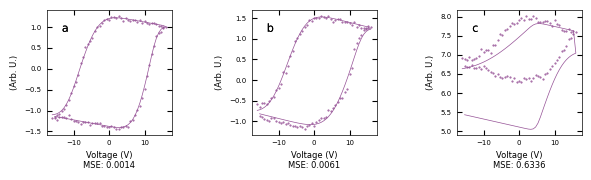

In [19]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    data,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

./Figures/Figure_X_NN_validation_Train.png
./Figures/Figure_X_NN_validation_Train.svg


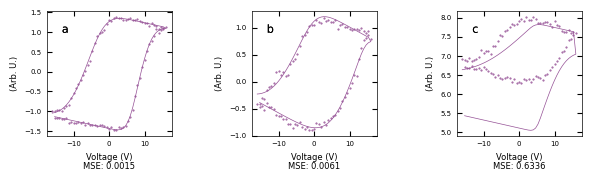

In [20]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

./Figures/Figure_X_NN_validation_Test.png
./Figures/Figure_X_NN_validation_Test.svg


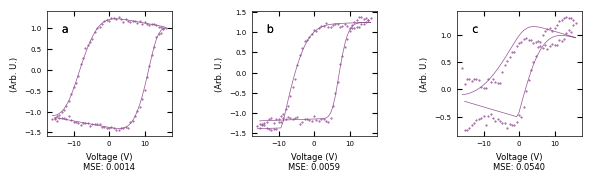

In [21]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)


### Calculate the MSE

In [22]:
data_ = (data, X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

BE_viz.dataset.print_hysteresis_mse(model, data_, labels)

Full Data Mean Squared Error: 0.0069
Test Data Mean Squared Error: 0.0066
Train Data Mean Squared Error: 0.0070


## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/hysteresis_comparison.png
./Figures/hysteresis_comparison.svg


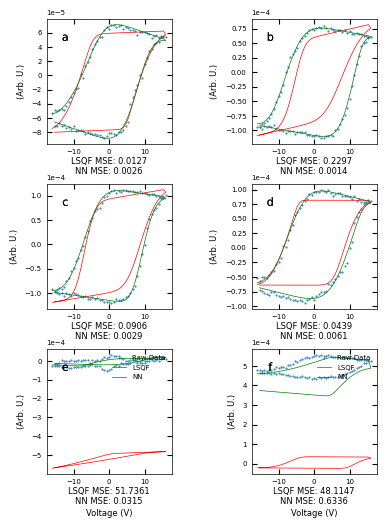

In [23]:
BE_viz.hysteresis_comparison(['LSQF','NN'],
                      row=None,
                      col=None,
                      cycle=None,
                      size=(1.25, 1.25),
                      gaps=(0.8, 0.4),
                      nn_model=model,
                      measurement_state=None,
                      filename="hysteresis_comparison")

### Statistics of the Results for Training, Validation, and Entire Dataset

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


ValueError: cannot reindex on an axis with duplicate labels

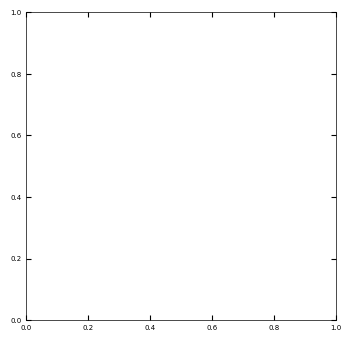

In [24]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
df, true, pred = BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.Tensor(data).reshape(-1,96)),
                                         filename="Figure_XX_Violin") 

### Color Maps of Parameters

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
data = torch.atleast_3d(torch.tensor(data.reshape(-1, 96))).float()

pred_recon, pred_params_scaled, pred_params = model.predict(
    data,
    1024,
    translate_params=False,
    is_SHO=False
)

BE_viz.hysteresis_maps(pred_params, filename="Figure_XX_NN_Hysteresis_Maps")

In [ ]:
data.shape

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
                                         filename="Figure_XX_Violin") 